Name: Holly Kular\
Date: 08-23-2024\
Email: hkular@ucsd.edu\
Description: plot results of decoding accuracy over time 

In [1]:
# imports
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.stats import sem, t, ttest_ind, pearsonr
import itertools
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
from matplotlib.animation import FuncAnimation
import scipy.stats as stats
import scikit_posthocs as sp
from scipy.stats import ttest_rel, f_oneway
from statsmodels.stats.multitest import multipletests

In [2]:
# which model do we want to explore
afc = 6
coh = 'lo'
mod = 2

In [3]:
# load model and trials

if sys.platform.startswith('linux'):
        data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
else:
        data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
        
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[mod]) 
model = loadmat(model_path)   
data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
data = np.load(data_file) #fr1 fr3 outs labs


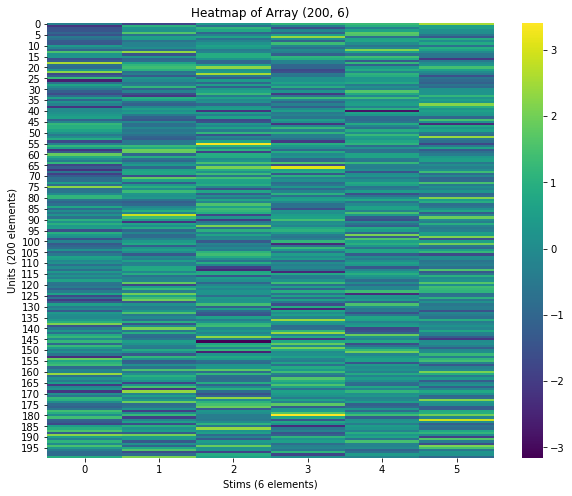

          Stim 0    Stim 1    Stim 2    Stim 3    Stim 4    Stim 5
Stim 0  1.000000 -0.034783 -0.008106  0.040914 -0.042835  0.028748
Stim 1 -0.034783  1.000000 -0.108905  0.043019 -0.016058 -0.023840
Stim 2 -0.008106 -0.108905  1.000000 -0.130088  0.097042 -0.148528
Stim 3  0.040914  0.043019 -0.130088  1.000000 -0.077563  0.029851
Stim 4 -0.042835 -0.016058  0.097042 -0.077563  1.000000  0.006734
Stim 5  0.028748 -0.023840 -0.148528  0.029851  0.006734  1.000000


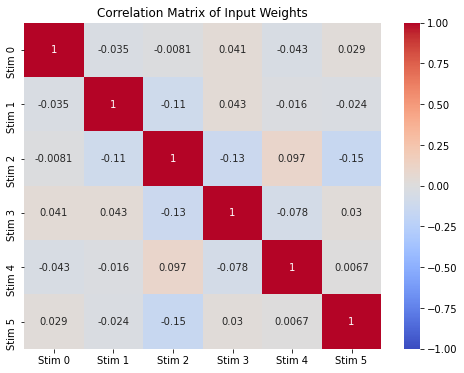

In [5]:
# let's check input weights first
# visualize to see if there is anything obvious
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(model['w_in0'], cmap='viridis', annot=False)  # 'cmap' can be changed to other color maps
plt.title('Heatmap of Array (200, 6)')
plt.xlabel('Stims (6 elements)')
plt.ylabel('Units (200 elements)')
plt.show()
# looks random and normal


df = pd.DataFrame(model['w_in0'], columns=[f'Stim {i}' for i in range(model['w_in0'].shape[1])])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Optionally, visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Input Weights')
plt.savefig('corr_w_in0_mod2.png')
plt.show()

Check stim selectivity

In [6]:
# calculate average firing rate for each unit across trials for each stimulus - do this using 6afc hi coh
data['fr3'].shape # trial x time x unit
# cut off time where there was no stimulus present
time_win = np.arange(0,250)
data['labs'].shape # trial x label

avg_fr1 = np.zeros((afc, data['fr1'].shape[1], data['fr1'].shape[2]))
avg_fr2 = np.zeros((afc, data['fr2'].shape[1], data['fr2'].shape[2]))
avg_fr3 = np.zeros((afc, data['fr3'].shape[1], data['fr3'].shape[2]))

for stim in np.arange(0,afc):
    ind = np.where(data['labs'] == stim)[0]
    avg_fr1[stim,:,:] = np.mean(data['fr1'][ind, :, :], axis = 0) 
    avg_fr2[stim, :, :] = np.mean(data['fr2'][ind, :,:], axis = 0)
    avg_fr3[stim,:,:] = np.mean(data['fr3'][ind, :, :], axis = 0)

    

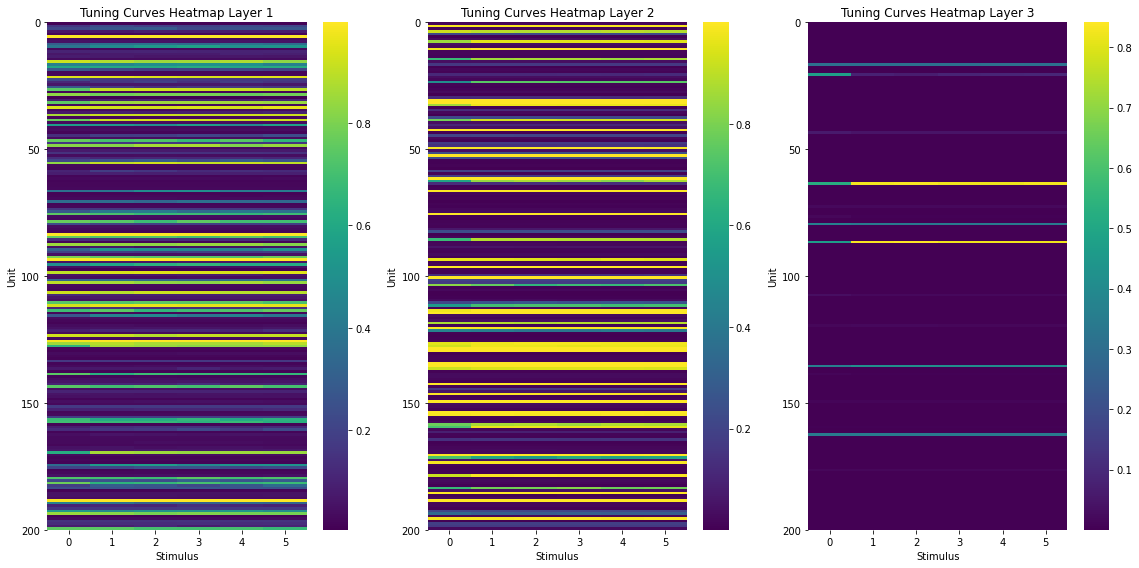

In [7]:
# plot averaged over time tuning curves
# mean over time
tuning_curves1 = np.mean(avg_fr1, axis=1).T
tuning_curves2 = np.mean(avg_fr2, axis=1).T
tuning_curves3 = np.mean(avg_fr3, axis=1).T

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot the first heatmap
sns.heatmap(tuning_curves1, cmap='viridis', cbar=True, xticklabels=range(afc), ax=axs[0])
axs[0].set_xlabel('Stimulus')
axs[0].set_ylabel('Unit')
axs[0].set_yticks(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[0].set_yticklabels(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[0].set_title('Tuning Curves Heatmap Layer 1')

# Plot the second heatmap
sns.heatmap(tuning_curves2, cmap='viridis', cbar=True, xticklabels=range(afc), ax=axs[1])
axs[1].set_xlabel('Stimulus')
axs[1].set_ylabel('Unit')
axs[1].set_yticks(np.arange(0, tuning_curves2.shape[0]+1, 50))
axs[1].set_yticklabels(np.arange(0, tuning_curves2.shape[0]+1, 50))
axs[1].set_title('Tuning Curves Heatmap Layer 2')

# Plot the second heatmap
sns.heatmap(tuning_curves3, cmap='viridis', cbar=True, xticklabels=range(afc), ax=axs[2])
axs[2].set_xlabel('Stimulus')
axs[2].set_ylabel('Unit')
axs[2].set_yticks(np.arange(0, tuning_curves3.shape[0]+1, 50))
axs[2].set_yticklabels(np.arange(0, tuning_curves3.shape[0]+1, 50))
axs[2].set_title('Tuning Curves Heatmap Layer 3')

# Show the figure
plt.tight_layout()
plt.savefig('time_avg_tuning_L123_mod2.png')
plt.show()


In [8]:
# quantify what I'm seeing is that more units are tuned for stim0 than the others and stim0 tuned units are more active only for layers 1 and 2
# paired t-tests with bonferroni correction for multiple comparisons
matrices = [tuning_curves1, tuning_curves2, tuning_curves3]

# Loop over each matrix
#for idx, matrix in enumerate(matrices, start=1):
#    print(f"\nResults for tuning_curves{idx}:")

#    p_values = []
    
    # Perform paired t-tests comparing column 0 with each other column
#    for col in range(1, matrix.shape[1]):
#        _, p_value = ttest_rel(matrix[:, 0], matrix[:, col])
#         p_values.append(p_value)

#     # Apply Bonferroni correction
#     alpha = 0.05
#     corrected_p_values = multipletests(p_values, alpha=alpha, method='bonferroni')[1]

#     # Print the corrected p-values
#     for col, p_val in enumerate(corrected_p_values, start=1):
#         print(f"Column 0 vs Column {col}: corrected p-value = {p_val:.3e}")


# # Loop over each matrix
# for idx, matrix in enumerate(matrices, start=1):
#     print(f"\nResults for tuning_curves{idx}:")

#     # Perform ANOVA on the columns of the matrix
#     f_stat, p_value = f_oneway(*[matrix[:, col] for col in range(matrix.shape[1])])

#     # Print the ANOVA result
#     print(f"ANOVA result: F-statistic = {f_stat:.3f}, p-value = {p_value:.3e}")
    
    
# follow-up paired t-test stim 0 versus avg of other stims
#Loop over each matrix

for idx, matrix in enumerate(matrices, start=1):
    print(f"\nResults for tuning_curves{idx}:")

    # Perform paired t-tests comparing column 0 with each other column
    t_stat, p_value = ttest_rel(matrix[:, 0], np.mean(matrix[:, 1:], axis = 1))

    # Apply Bonferroni correction
    alpha = 0.05
    corrected_p_value = multipletests(p_value, alpha=alpha, method='bonferroni')[1]

    # Print the corrected p-values
    print(f"Column 0 vs Others: corrected p-value = {corrected_p_value.item() :.3e}")



Results for tuning_curves1:
Column 0 vs Others: corrected p-value = 7.293e-03

Results for tuning_curves2:
Column 0 vs Others: corrected p-value = 4.432e-03

Results for tuning_curves3:
Column 0 vs Others: corrected p-value = 6.776e-01


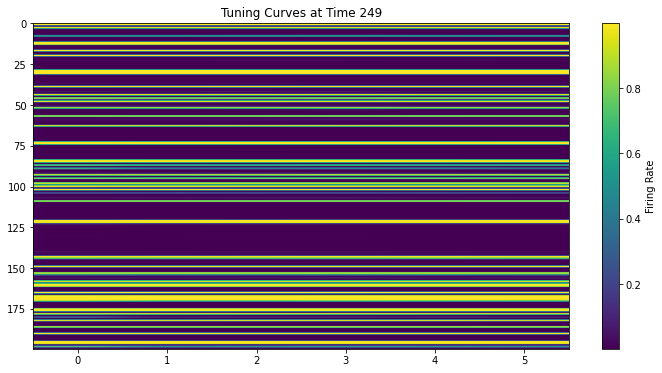

In [56]:
# show time dynamics

fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.imshow(avg_fr2.T[:, 0, :], aspect='auto', cmap='viridis')
plt.colorbar(cax, ax=ax, label='Firing Rate')

def update(frame):
    cax.set_array(avg_fr2.T[:, frame, :])
    ax.set_title(f'Tuning Curves at Time {frame}')
    return cax,

ani = FuncAnimation(fig, update, frames=range(avg_fr2.T.shape[1]), blit = True)

ani.save('fr2_tuning.gif', writer = "pillow", fps = 5)

plt.show()

# firing rate seems to be more consistent within a unit rather than attracted to partiular stimuli

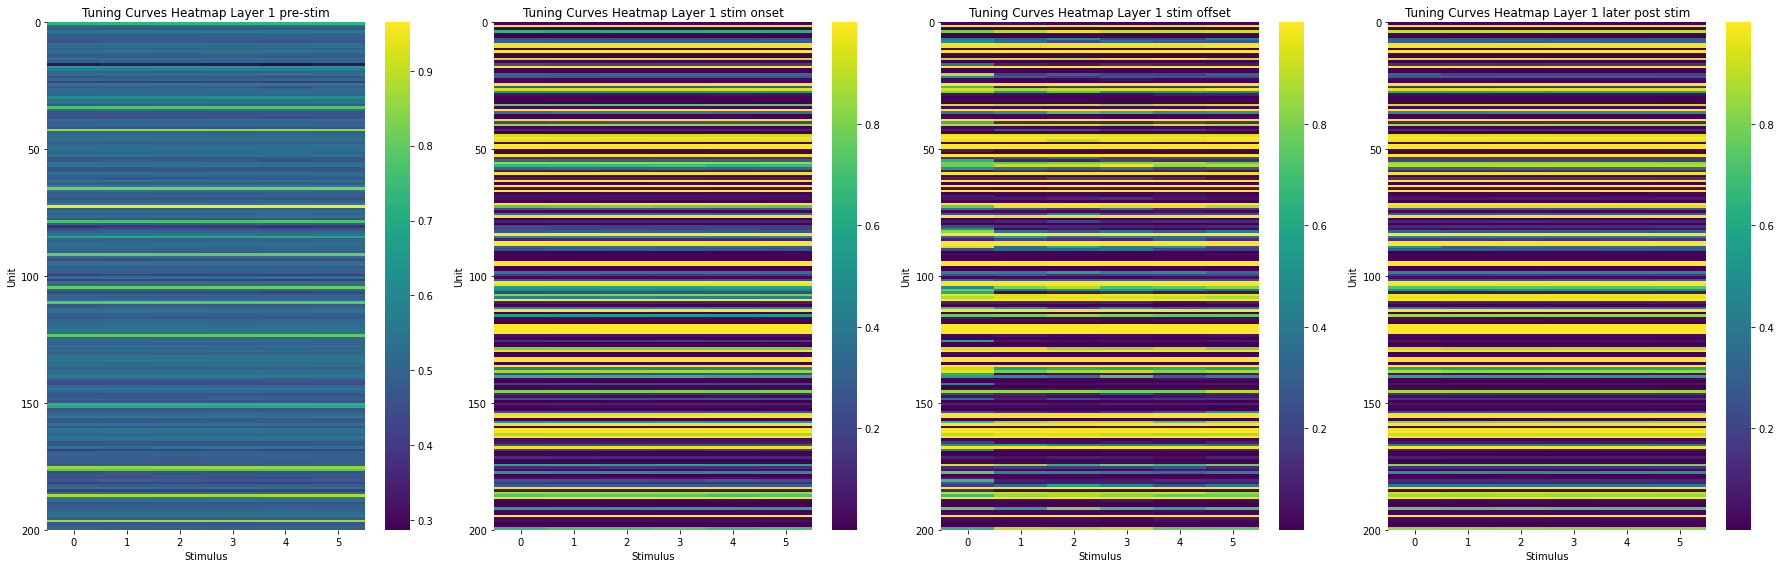

In [52]:
# show time beginning and end

tuning_curves1 = avg_fr1.T[:, 0, :] # beginning
tuning_curves2 = avg_fr1.T[:, 80, :] # stim onset
tuning_curves3 = avg_fr1.T[:, 131, :] # stim offset
tuning_curves4 = avg_fr1.T[:, 200, :]  # later off sitm

# Create a figure with two subplots
fig, axs = plt.subplots(1, 4, figsize=(25, 8))

# Plot the first heatmap
sns.heatmap(tuning_curves1, cmap='viridis', cbar=True, xticklabels=range(afc), ax=axs[0])
axs[0].set_xlabel('Stimulus')
axs[0].set_ylabel('Unit')
axs[0].set_yticks(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[0].set_yticklabels(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[0].set_title('Tuning Curves Heatmap Layer 1 pre-stim')

# Plot the second heatmap
sns.heatmap(tuning_curves2, cmap='viridis', cbar=True, xticklabels=range(afc), ax=axs[1])
axs[1].set_xlabel('Stimulus')
axs[1].set_ylabel('Unit')
axs[1].set_yticks(np.arange(0, tuning_curves1.shape[0]+1, 50)) 
axs[1].set_yticklabels(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[1].set_title('Tuning Curves Heatmap Layer 1 stim onset')

# Plot the third heatmap
sns.heatmap(tuning_curves3, cmap='viridis', cbar=True, xticklabels=range(afc), ax=axs[2])
axs[2].set_xlabel('Stimulus')
axs[2].set_ylabel('Unit')
axs[2].set_yticks(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[2].set_yticklabels(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[2].set_title('Tuning Curves Heatmap Layer 1 stim offset')

# Plot the fourth heatmap
sns.heatmap(tuning_curves4, cmap='viridis', cbar=True, xticklabels=range(afc), ax=axs[3])
axs[3].set_xlabel('Stimulus')
axs[3].set_ylabel('Unit')
axs[3].set_yticks(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[3].set_yticklabels(np.arange(0, tuning_curves1.shape[0]+1, 50))
axs[3].set_title('Tuning Curves Heatmap Layer 1 later post stim')

# Show the figure
plt.tight_layout()
plt.show()

In [55]:
# statistical test to see whether certain stims have more tuned units than others

# firing_rates is a 2D array where rows represent stimuli and columns represent units
firing_rates = avg_fr3.T[:,200,:]

h_statistic, p_value = stats.kruskal(*firing_rates)
p_values = sp.posthoc_dunn(firing_rates.T, p_adjust = 'holm')

print(p_values>.01)



# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

d_primes = []
for n in np.array((0,2,3,4,5)):
    d_primes.append(cohend(firing_rates[:,1], firing_rates[:,n]))
    
# cohens d basically zero at time 80, so effect size is miniscule even if p_vals are significant
# d-primes small at time 131 and zero at time 200 
print(d_primes)

      1     2     3     4     5     6
1  True  True  True  True  True  True
2  True  True  True  True  True  True
3  True  True  True  True  True  True
4  True  True  True  True  True  True
5  True  True  True  True  True  True
6  True  True  True  True  True  True
[0.0052521093788984894, 0.0001716491257861281, 1.522509408255662e-05, -0.0015193112040395378, 0.00022322343504568886]


In [ ]:
# Tuning based on trial type

# stim 0 trials

# stim 1-6 trials grouped

# stim individual trials
